# Testing Contribution Transmission + Clouds

First, we define a planet that we will be using for the rest of the dictionary (Wasp-17b)

In [1]:
from POSEIDON.core import wl_grid_constant_R
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J, M_J
import scipy.constants as sc 
from POSEIDON.clouds import vary_one_parameter, contribution_clouds_transmission, plot_clouds

import numpy as np
import matplotlib.pyplot as plt

#***** Define stellar properties *****#

R_s = 1.49*R_Sun     # Stellar radius (m)
T_s = 6550            # Stellar effective temperature (K)
Met_s = -0.25          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.2        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'Clouds'  # Planet name used for plots, output files etc.

R_p = 1.87*R_J                           # Planetary radius (m)
R_p = 1.722*R_J
M_p = 0.78*M_J
g_p = (sc.G*M_p)/(R_p**2)         # Gravitational field of planet (m/s^2)
T_eq = 1447

# Create the planet object
planet = create_planet(planet_name, R_p, gravity = g_p, T_eq = T_eq)

CB_color_cycle = ['#0072B2', '#009E73', '#D55E00', '#CC79A7',
                 '#F0E442', '#56B4E9','#56B4E9']

# Intialize wavelength grid
wl_min = 0.2    # Minimum wavelength (um)
wl_max = 13      # Maximum wavelength (um)
R = 10000       # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p # Radius at reference pressure

/Users/elijahmullens/Desktop/POSEIDON-V1-1/POSEIDON/absorption.py:1493: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def store_Rayleigh_eta_LBL(wl_model, chemical_species):


In [2]:
from POSEIDON.core import read_opacities
from POSEIDON.core import define_model

model_name = 'Load-Opac'

bulk_species = ['H2','He']
param_species = ['H2O']

model_load_opac = define_model(model_name,bulk_species,param_species,
                               PT_profile = 'isotherm', X_profile = 'isochem')

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the 
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 400     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2000    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model_load_opac, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2O done
Opacity pre-interpolation complete.


# Deck Haze Model
<a id='1'></a>
This model implements an opaque cloud extending up to $P_{cloud}$ below which no electromagnetic radiation can pass through, and a haze that is uniformly distributed throughout the atmosphere. This model fits for both a flattening of a spectrum due to an opaque cloud deck and an 'amplified' short wavelngth slope that can obscure Na, K, TiO, VO, etc absorption features. 
<br><br>
Note that this model in a retrieval will fit for the short wavelength slope by design. However, the 'haze' in this model is a mathematical perscription and does not represent a 'real' molecule. See Mie Scattering sections for how to implement a 'real' aerosol or haze species. 
<br><br>
$\lambda_0$ is the reference wavelength (350 nm), $\sigma_0$ is the H2-Rayleigh scattering cross section at the reference wavelength (5.31e-31 $m^2$), a is the Rayleigh-enhancement factor and $\gamma$ is the scattering slope. 
<br><br>

$$
\begin{equation}
\kappa_{cloud}=
    \begin{cases}
        a \sigma_0 (\lambda / \lambda_0)^{\gamma} & P < P_{cloud}\\
        \infty & P \geq P_{cloud}
    \end{cases}
\end{equation}
$$

<br><br>

We will explore how each 'tunable' parameter affects a spectrum. 

In [3]:
from POSEIDON.core import define_model

model_name = 'Deck-Haze'

bulk_species = ['H2','He']
param_species = ['H2O']

model_deck_haze = define_model(model_name,bulk_species,param_species,
                               PT_profile = 'isotherm', X_profile = 'isochem',
                               cloud_model = 'MacMad17', cloud_type = 'deck_haze')

print("PT parameters : " + str(model_deck_haze['PT_param_names']))
print("X parameters : " + str(model_deck_haze['X_param_names']))
print("Cloud parameters : " + str(model_deck_haze['cloud_param_names']))

PT parameters : ['T']
X parameters : ['log_H2O']
Cloud parameters : ['log_a' 'gamma' 'log_P_cloud']


In [4]:
from POSEIDON.core import make_atmosphere

# PT and X parameters
T = 1200
log_H2O = -4

# Cloud Parameters 
log_a       = 1.7
gamma       = -8 
log_P_cloud = -2

PT_params = np.array([T])
log_X_params = np.array([log_H2O])
cloud_params = np.array([log_a, gamma, log_P_cloud])

# Make atmosphere 
atmosphere_deck_haze = make_atmosphere(planet, model_deck_haze, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

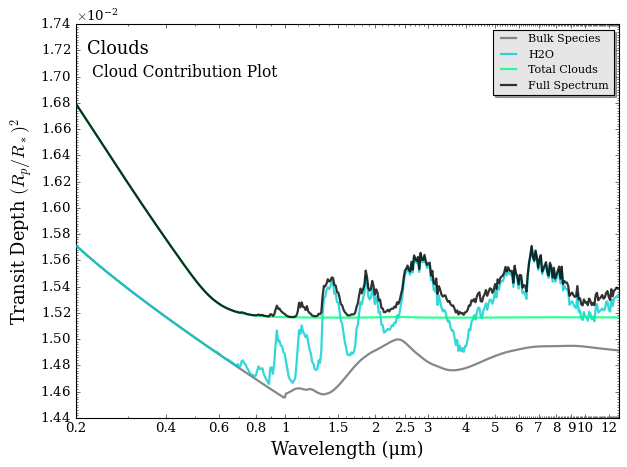

In [5]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_deck_haze, atmosphere_deck_haze, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            put_one_in = True,
                                                                                            take_one_out = False,
                                                                                            fix_mu = True)

plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list)

In [6]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Fuzzy_Deck_SiO2'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2']

model_fuzzy_deck = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'fuzzy_deck',
                     aerosol_species = aerosol_species)


# Check the free parameters defining this model
print("PT parameters : " + str(model_fuzzy_deck['PT_param_names']))
print("X parameters : " + str(model_fuzzy_deck['X_param_names']))
print("Cloud parameters : " + str(model_fuzzy_deck['cloud_param_names']))


Reading in database for aerosol cross sections...
PT parameters : ['T']
X parameters : ['log_H2O']
Cloud parameters : ['log_P_top_deck_SiO2' 'log_r_m_SiO2' 'log_n_max_SiO2' 'f_SiO2']


In [7]:
from POSEIDON.core import make_atmosphere

# PT and X parameters
T = 1200
log_H2O = -4

# Cloud Parameters 
log_P_top_deck_SiO2 = 0
log_r_m_SiO2        = -2
log_n_max_SiO2      = 20
f_SiO2              = 0.3

PT_params = np.array([T])
log_X_params = np.array([log_H2O])
cloud_params = np.array([log_P_top_deck_SiO2, log_r_m_SiO2, log_n_max_SiO2, f_SiO2])

# Make atmosphere 
atmosphere_fuzzy_deck = make_atmosphere(planet, model_fuzzy_deck, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

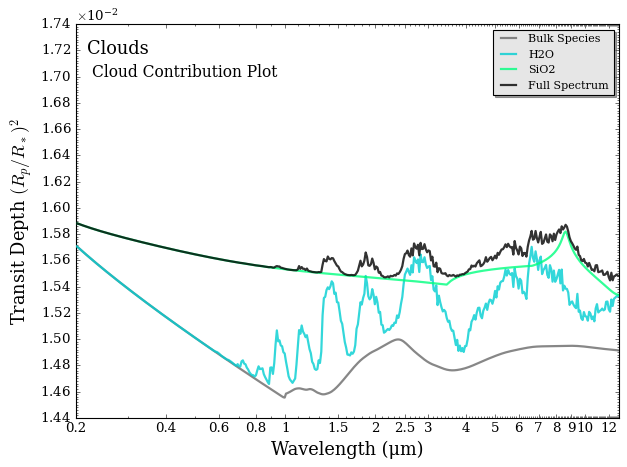

In [8]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_fuzzy_deck, atmosphere_fuzzy_deck, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_species_list = ['SiO2'],
                                                                                            put_one_in = True,
                                                                                            take_one_out = False,
                                                                                            fix_mu = True)

plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list)

# 1 Slab

In [3]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Slab_SiO2'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2']

model_slab = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'slab',
                     aerosol_species = aerosol_species)


# Check the free parameters defining this model
print("PT parameters : " + str(model_slab['PT_param_names']))
print("X parameters : " + str(model_slab['X_param_names']))
print("Cloud parameters : " + str(model_slab['cloud_param_names']))


Reading in database for aerosol cross sections...
PT parameters : ['T']
X parameters : ['log_H2O']
Cloud parameters : ['log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2']


In [4]:
from POSEIDON.core import make_atmosphere

# PT and X parameters
T = 1200
log_H2O = -4

# Cloud Parameters 
log_P_top_slab_SiO2 = -5
Delta_log_P_SiO2    = 2
log_r_m_SiO2        = -2
log_X_SiO2          = -12

PT_params = np.array([T])
log_X_params = np.array([log_H2O])
cloud_params = ([log_P_top_slab_SiO2,Delta_log_P_SiO2,log_r_m_SiO2,log_X_SiO2])

# Make atmosphere 
atmosphere_slab = make_atmosphere(planet, model_slab, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

In [20]:
def plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                               full_spectrum_first = True):

    from POSEIDON.utility import plot_collection
    from POSEIDON.visuals import plot_spectra

    spectra = []

    if full_spectrum_first == True:
        colour_list = ['black','dimgray', 'darkturquoise', 'green', 'darkorchid', 'salmon', '#ff7f00', 'hotpink', 'red', 'orange', 'green', 'blue', 'purple']

        spectra = plot_collection(spectrum, wl, collection = spectra)
        spectrum_contribution_list_names.insert(0,'Full Spectrum')
        print(spectrum_contribution_list_names)

        # Loop through the contribution spectra 
        for s in spectrum_contribution_list:
            spectra = plot_collection(s, wl, collection = spectra)

        # Plot the full spectrum last so its on top 

        colour_list = colour_list[:len(spectrum_contribution_list)+1]
        
        fig = plot_spectra(spectra, planet, R_to_bin = 100,
                    plt_label = 'Cloud Contribution Plot',
                    spectra_labels = spectrum_contribution_list_names,
                    plot_full_res = False, 
                    save_fig = False,
                    colour_list = colour_list)
        
    else: 
        
        colour_list = ['dimgray', 'darkturquoise', 'green', 'darkorchid', 'salmon', '#ff7f00', 'hotpink', 'red', 'orange', 'green', 'blue', 'purple']

        spectra = []
        # Loop through the contribution spectra 
        for s in spectrum_contribution_list:
            spectra = plot_collection(s, wl, collection = spectra)

        # Plot the full spectrum last so its on top 
        spectra = plot_collection(spectrum, wl, collection = spectra)

        colour_list = colour_list[:len(spectrum_contribution_list)]
        colour_list.append('black')
        spectrum_contribution_list_names.append('Full Spectrum')

        
        fig = plot_spectra(spectra, planet, R_to_bin = 100,
                    plt_label = 'Cloud Contribution Plot',
                    spectra_labels = spectrum_contribution_list_names ,
                    plot_full_res = False, 
                    save_fig = False,
                    colour_list = colour_list)

['Full Spectrum', 'Bulk Species', 'H2O', 'SiO2']


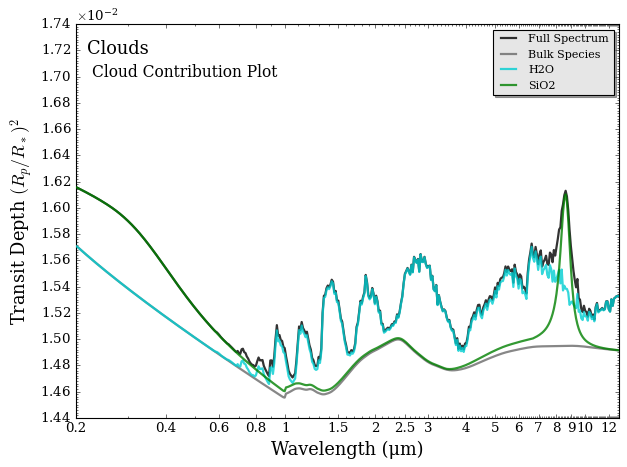

In [21]:
from POSEIDON.contributions import spectral_contribution
#plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_slab, atmosphere_slab, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_species_list = ['SiO2'],
                                                                                            put_one_in = True,
                                                                                            take_one_out = False,
                                                                                            fix_mu = True)

plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list)

# Complicated Models

In [6]:
model_name = 'Multiple_Slabs'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']

aerosol_species = ['SiO2', 'MgSiO3']

model_multiple_slabs = define_model(model_name, bulk_species, param_species,
                                    PT_profile = 'isotherm', X_profile = 'isochem',
                                    cloud_model = 'Mie',cloud_type = 'slab',
                                    aerosol_species = aerosol_species)

model_name = 'Opaque_deck_plus_slab'

model_opaque_plus_slabs = define_model(model_name, bulk_species, param_species,
                                        PT_profile = 'isotherm', X_profile = 'isochem',
                                        cloud_model = 'Mie',cloud_type = 'opaque_deck_plus_slab',
                                        aerosol_species = aerosol_species)

model_name = 'Fuzzy_deck_plus_slab'
aerosol_species = ['Fe','SiO2', 'MgSiO3']

model_fuzzy_deck_plus_slabs = define_model(model_name, bulk_species, param_species,
                                            PT_profile = 'isotherm', X_profile = 'isochem',
                                            cloud_model = 'Mie',cloud_type = 'fuzzy_deck_plus_slab',
                                            aerosol_species = aerosol_species)

print()
print("Cloud parameters (slabs) : " + str(model_multiple_slabs['cloud_param_names']))
print()
print("Cloud parameters (opaque deck + slabs) : " + str(model_opaque_plus_slabs['cloud_param_names']))
print()
print("Cloud parameters (fuzzy deck + slabs) : " + str(model_fuzzy_deck_plus_slabs['cloud_param_names']))

Reading in database for aerosol cross sections...
Reading in database for aerosol cross sections...
This mode assumes that the first aerosol in the list is the deck species, rest are slab species
Reading in database for aerosol cross sections...

Cloud parameters (slabs) : ['log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2'
 'log_P_top_slab_MgSiO3' 'Delta_log_P_MgSiO3' 'log_r_m_MgSiO3'
 'log_X_MgSiO3']

Cloud parameters (opaque deck + slabs) : ['log_P_top_deck' 'log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2'
 'log_X_SiO2' 'log_P_top_slab_MgSiO3' 'Delta_log_P_MgSiO3'
 'log_r_m_MgSiO3' 'log_X_MgSiO3']

Cloud parameters (fuzzy deck + slabs) : ['log_P_top_deck_Fe' 'log_r_m_Fe' 'log_n_max_Fe' 'f_Fe'
 'log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2'
 'log_P_top_slab_MgSiO3' 'Delta_log_P_MgSiO3' 'log_r_m_MgSiO3'
 'log_X_MgSiO3']


In [7]:
from POSEIDON.core import make_atmosphere

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

# Slabs 
log_P_top_slab_SiO2 = -5
Delta_log_P_SiO2    = 1
log_r_m_SiO2        = -2
log_X_SiO2          = -12

log_P_top_slab_MgSiO3 = - 3
Delta_log_P_MgSiO3    = 1
log_r_m_MgSiO3        = -2
log_X_MgSiO3          = -13

cloud_params = ([log_P_top_slab_SiO2, Delta_log_P_SiO2, log_r_m_SiO2, log_X_SiO2, 
                 log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3,log_X_MgSiO3])
                 
atmosphere_multiple_slabs = make_atmosphere(planet, model_multiple_slabs, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)


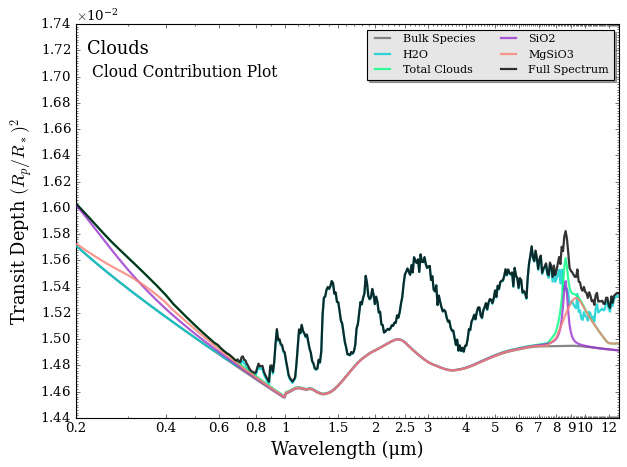

In [8]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_multiple_slabs, atmosphere_multiple_slabs, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_species_list = ['SiO2', 'MgSiO3'],
                                                                                            cloud_total_contribution= True,
                                                                                            put_one_in = True,
                                                                                            take_one_out = False,
                                                                                            fix_mu = True)

plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list)

In [ ]:
# Opaque + Slabs
log_P_top_deck        = -2

cloud_params = ([log_P_top_deck,
                 log_P_top_slab_SiO2,Delta_log_P_SiO2,log_r_m_SiO2,log_X_SiO2,
                 log_P_top_slab_MgSiO3,Delta_log_P_MgSiO3, log_r_m_MgSiO3,log_X_MgSiO3])

atmosphere_opaque_plus_slabs = make_atmosphere(planet, model_opaque_plus_slabs, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

In [ ]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_opaque_plus_slabs, atmosphere_opaque_plus_slabs, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_species_list = ['SiO2', 'MgSiO3'],
                                                                                            cloud_total_contribution= True,
                                                                                            put_one_in = True,
                                                                                            take_one_out = False,
                                                                                            fix_mu = True)

plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list)

Note that the contribution function does not show the deck seperately. However, as shown before, it just flattens the spectrum

In [ ]:
# Fuzzy Deck + Slabs
log_P_top_deck_Fe     = 0
log_r_m_Fe            = -2
log_n_max_Fe          = 20
f_Fe                  = 0.2


cloud_params = ([log_P_top_deck_Fe,log_r_m_Fe,log_n_max_Fe,f_Fe,
                 log_P_top_slab_SiO2,Delta_log_P_SiO2,log_r_m_SiO2,log_X_SiO2,
                 log_P_top_slab_MgSiO3,Delta_log_P_MgSiO3,log_r_m_MgSiO3,log_X_MgSiO3])

atmosphere_fuzzy_deck_plus_slabs = make_atmosphere(planet, model_fuzzy_deck_plus_slabs, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

In [ ]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_fuzzy_deck_plus_slabs, atmosphere_fuzzy_deck_plus_slabs, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_species_list = ['Fe','SiO2', 'MgSiO3'],
                                                                                            cloud_total_contribution= True,
                                                                                            put_one_in = True,
                                                                                            take_one_out = False,
                                                                                            fix_mu = True)

plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list)

## Uniform X 

In [ ]:
model_name = 'Uniform_X'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2']

model_uniform_x = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'uniform_X',
                     aerosol_species = aerosol_species)

print()
print("Cloud parameters (Uniform X) : " + str(model_uniform_x['cloud_param_names']))

Reading in database for aerosol cross sections...

Cloud parameters (Uniform X) : ['log_r_m_SiO2' 'log_X_SiO2']


In [ ]:
from POSEIDON.core import make_atmosphere

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

# Slabs 
log_r_m_SiO2        = -2
log_X_SiO2          = -12

cloud_params = ([log_r_m_SiO2, log_X_SiO2])
                 
atmosphere_uniform_x = make_atmosphere(planet, model_uniform_x, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)


In [ ]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_uniform_x, atmosphere_uniform_x, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_species_list = ['SiO2'],
                                                                                            put_one_in = True,
                                                                                            take_one_out = False,
                                                                                            fix_mu = True)

plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list)

In [ ]:
bulk_species = ['H2', 'He']     
param_species = ['H2O']

model_name = 'File_Read'
aerosol_species = ['file_read']

model_file_read = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'uniform_X',
                     aerosol_species = aerosol_species)

model_name = 'Free'
aerosol_species = ['free']
model_free = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'uniform_X',
                     aerosol_species = aerosol_species)

print()
print("Cloud parameters (File Read) : " + str(model_file_read['cloud_param_names']))
print()
print("Cloud parameters (Free) : " + str(model_free['cloud_param_names']))


Cloud parameters (File Read) : ['log_r_m' 'log_X_Mie' 'r_i_real' 'r_i_complex']

Cloud parameters (Free) : ['log_r_m' 'log_X_Mie' 'r_i_real' 'r_i_complex']


In [ ]:
from POSEIDON.clouds import load_refractive_indices_from_file

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

# Cloud Params 
log_r_m        = -2
log_X_Mie          = -12
# Preload the refractive indices from the file 
file_name = './H2O_complex.txt'
r_i_real, r_i_complex = load_refractive_indices_from_file(wl, file_name)

cloud_params = ([log_r_m, log_X_Mie, r_i_real, r_i_complex])
atmosphere_file_read = make_atmosphere(planet, model_file_read, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Loading in :  ./H2O_complex.txt


In [ ]:
# Constant refractive indices 
r_i_real, r_i_complex = 1, 1e-3
cloud_params = ([log_r_m, log_X_Mie, r_i_real, r_i_complex])
atmosphere_free = make_atmosphere(planet, model_free, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

In [ ]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_file_read, atmosphere_file_read, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_species_list = ['file_read'],
                                                                                            put_one_in = True,
                                                                                            take_one_out = False,
                                                                                            fix_mu = True)

plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list)

In [ ]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_free, atmosphere_free, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_species_list = ['free'],
                                                                                            put_one_in = True,
                                                                                            take_one_out = False,
                                                                                            fix_mu = True)

plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list)